In [81]:
from SOH_func import *
import matplotlib.pyplot as pl
from tensorflow import keras
from keras import models, layers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
# from sklearn.preprocessing import StandardScaler

In [82]:
FILE_NAME = 'CYCLE_CSV_data.csv'
# drop_labels = ['시험_시간(s)', '사이클_번호', '사이클_시간(s)', '단계_번호', '단계_시간(s)', '인덱스', '보조전압1(V)', '보조전압2(V)', '보조전압3(V)', '온도(\'C)', '누적_용량(Ah)', '전류_범위', 'OCP(V)', '파워(W)', '부하(Ohm)']
drop_labels_x = ['인덱스', '사이클_번호', '충전_용량(Ah)', '누적_용량(Ah)', '충전_에너지(Wh)', '누적_에너지(Wh)', '쿨롱_효율(%)', '에너지_효율(%)', '최대_전압(V)', '충전_최종전압(V)', '단위_충전_용량(Ah/g)', '단위_방전_용량(Ah/g)']
drop_labels_y = ['인덱스', '사이클_번호', '충전_용량(Ah)', '누적_용량(Ah)', '충전_에너지(Wh)', '방전_에너지(Wh)', '누적_에너지(Wh)', '쿨롱_효율(%)', '에너지_효율(%)', '최대_전압(V)', '충전_최종전압(V)', '방전_최종전압(V)', '단위_충전_용량(Ah/g)', '단위_방전_용량(Ah/g)']
y_label = '절대값_용량(Ah)'

Index(['방전_용량(Ah)', '방전_에너지(Wh)', '방전_최종전압(V)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
data = (510, 3)
data_cap = (510, 1)


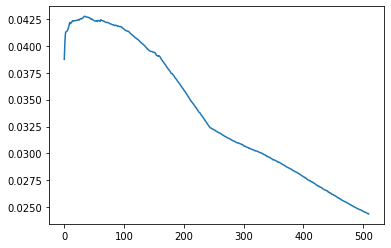

In [83]:
data, data_cap = get_data(FILE_NAME, drop_labels_x, drop_labels_y)
print(f'data = {data.shape}')
print(f'data_cap = {data_cap.shape}')
pl.plot(data_cap)
pl.show()

In [84]:
seq_len = 30
num_units = 256
num_filters = num_units
window = 3
drop_rate = 0.2
num_epochs = 10000
x_train, y_train, x_test, y_test = seq_gen(data, data_cap, seq_len)

num_batch = 16
x = (16, 30, 3)
y = (16, 30, 1)
split_len = 12
(12, 30, 1)


In [85]:
model = models.Sequential()
model.add(layers.ConvLSTM1D(num_filters, window, return_sequences=True, input_shape = (None, x_train.shape[-2], x_train.shape[-1])))
model.add(layers.Dense(1))
model.compile(loss = 'mse', optimizer = 'Adam')
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm1d_16 (ConvLSTM1D)  (None, None, 28, 256)    796672    
                                                                 
 dense_1 (Dense)             (None, None, 28, 1)       257       
                                                                 
Total params: 796,929
Trainable params: 796,929
Non-trainable params: 0
_________________________________________________________________


In [86]:
epoch_index = 0
loss_dict = {}
epoch_index += num_epochs
callback_list = [ModelCheckpoint(filepath = f'Checkpoints\SOC_Checkpoint_{epoch_index}.h5', monitor = 'val_loss', save_best_only = True)]
fitdata = model.fit(x_train, y_train, epochs=num_epochs, verbose = 1, validation_split=0.2, callbacks=callback_list)

Epoch 1/10000


ValueError: in user code:

    File "c:\Users\deep\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\deep\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\deep\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\deep\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\deep\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\deep\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_16" is incompatible with the layer: expected shape=(None, None, 30, 3), found shape=(None, 30, 3)


In [ ]:
model.load_weights(f'Checkpoints\SOC_Checkpoint_{epoch_index}.h5')
loss = model.evaluate(x_test, y_test)
loss_dict[f'loss_{epoch_index}'] = loss # 딕셔너리에 현 에포크까지의 손실 함수 값 저장
prediction = model.predict(x_train) # 현 상태에서 추론
prediction = prediction.reshape(int(prediction.shape[0] * prediction.shape[1]), 1) # 추론 값은 시퀀스 단위로 나뉘어 있으므로 1차원 데이터로 가공
y_graph = y_train.reshape(int(y_train.shape[0] * y_train.shape[1]), 1) # y_test 데이터 역시 1차원 데이터로 가공
print(prediction.shape, y_graph.shape)

1/1 [==============================] - 0s 337ms/step
(360, 1) (360, 1)


512 units, 5000 epochs, sequence length = 30


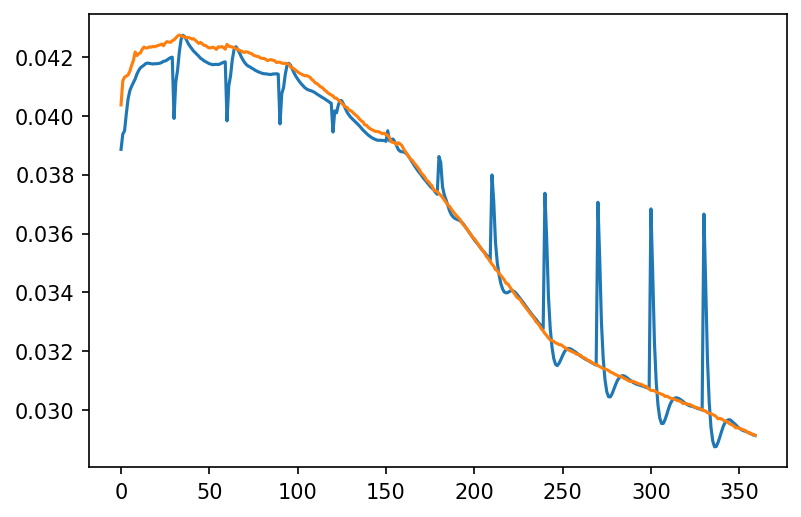

In [ ]:
print(f'{num_units} units, {epoch_index} epochs, sequence length = {seq_len}')
pl.figure(dpi=150) # 해상도(default = 100)
pl.plot(prediction)
pl.plot(y_graph)
pl.show()
pl.savefig(f'ouputs/out_{num_filters}fil{num_units}memc{epoch_index}epoch{seq_len}seq')